In [123]:
from vimba import *
from typing import Optional
import cv2
import pylab as pl
import numpy as np

In [2]:
with Vimba.get_instance() as vimba:
    cams = vimba.get_all_cameras()
    print('Cameras found: {}'.format(len(cams)))

Cameras found: 2


In [3]:
cams[0].get_id()

'DEV_1AB22C00722F'

In [127]:
with Vimba.get_instance() as vimba:
#     cam = vimba.get_camera_by_id(cams[0].get_id())
    cams = vimba.get_all_cameras()
    with cams[1] as cam:
        cam.set_pixel_format(PixelFormat.Mono8)
        frame = cam.get_frame()
        frame.convert_pixel_format(PixelFormat.Mono8)
        cam.ExposureTime.set(100000) #100m exposure
        cam.Gain.set(20)
        dt = cam.ExposureTime.get()
        dg = cam.Gain.get()

In [128]:
# 1440 x 1700 per eye, 1700 is hight, and 2880 is total width

In [129]:
img = frame.as_opencv_image()
resized = cv2.resize(img, (1440, 1700), interpolation=cv2.INTER_LINEAR)

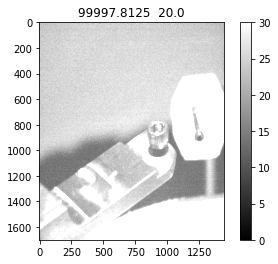

In [130]:
pl.imshow(resized, cmap='gray', vmin=0, vmax = 30)
pl.title(str(dt) + '  ' + str(dg))
pl.colorbar()

In [131]:
resizedb = resized

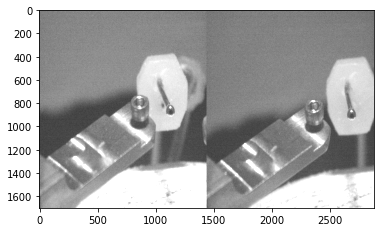

In [133]:
vis = np.concatenate((resizedA, resizedb), axis=1)
pl.imshow(vis, cmap='gray', vmin=0, vmax = 50)

In [ ]:
gain: 23
    also set gamma to as small as possible

In [1]:
import copy
import cv2
import threading
import queue
import numpy

from typing import Optional
from vimba import *

In [2]:
FRAME_QUEUE_SIZE = 10
FRAME_HEIGHT = 850#1700
FRAME_WIDTH = 720#1440

In [3]:
def add_camera_id(frame: Frame, cam_id: str) -> Frame:
    # Helper function inserting 'cam_id' into given frame. This function
    # manipulates the original image buffer inside frame object.
    cv2.putText(frame.as_opencv_image(), 'Cam: {}'.format(cam_id), org=(0, 30), fontScale=1,
                color=255, thickness=1, fontFace=cv2.FONT_HERSHEY_COMPLEX_SMALL)
    return frame


def resize_if_required(frame: Frame) -> numpy.ndarray:
    # Helper function resizing the given frame, if it has not the required dimensions.
    # On resizing, the image data is copied and resized, the image inside the frame object
    # is untouched.
    cv_frame = frame.as_opencv_image()

    if (frame.get_height() != FRAME_HEIGHT) or (frame.get_width() != FRAME_WIDTH):
        cv_frame = cv2.resize(cv_frame, (FRAME_WIDTH, FRAME_HEIGHT), interpolation=cv2.INTER_LINEAR)
#         cv_frame = cv_frame[..., numpy.newaxis]

    return cv_frame


def set_exposure(cam: Camera, increment):
    """
    Increments the camera exposure by a multiple of the smallest step
    """
    with Vimba.get_instance() as vimba:
        cam.ExposureTime.set(100000) #100m exposure
        cam.Gain.set(20)


def create_dummy_frame() -> numpy.ndarray:
    cv_frame = numpy.zeros((50, 640, 1), numpy.uint8)
    cv_frame[:] = 0

    cv2.putText(cv_frame, 'No Stream available. Please connect a Camera.', org=(30, 30),
                fontScale=1, color=255, thickness=1, fontFace=cv2.FONT_HERSHEY_COMPLEX_SMALL)

    return cv_frame


def try_put_frame(q: queue.Queue, cam: Camera, frame: Optional[Frame]):
    try:
        q.put_nowait((cam.get_id(), frame))

    except queue.Full:
        pass


def set_nearest_value(cam: Camera, feat_name: str, feat_value: int):
    # Helper function that tries to set a given value. If setting of the initial value failed
    # it calculates the nearest valid value and sets the result. This function is intended to
    # be used with Height and Width Features because not all Cameras allow the same values
    # for height and width.
    feat = cam.get_feature_by_name(feat_name)

    try:
        feat.set(feat_value)

    except VimbaFeatureError:
        min_, max_ = feat.get_range()
        inc = feat.get_increment()

        if feat_value <= min_:
            val = min_

        elif feat_value >= max_:
            val = max_

        else:
            val = (((feat_value - min_) // inc) * inc) + min_

        feat.set(val)

        msg = ('Camera {}: Failed to set value of Feature \'{}\' to \'{}\': '
               'Using nearest valid value \'{}\'. Note that, this causes resizing '
               'during processing, reducing the frame rate.')
        Log.get_instance().info(msg.format(cam.get_id(), feat_name, feat_value, val))


# Thread Objects
class FrameProducer(threading.Thread):
    def __init__(self, cam: Camera, frame_queue: queue.Queue):
        threading.Thread.__init__(self)

        self.log = Log.get_instance()
        self.cam = cam
        self.frame_queue = frame_queue
        self.killswitch = threading.Event()

    def __call__(self, cam: Camera, frame: Frame):
        # This method is executed within VimbaC context. All incoming frames
        # are reused for later frame acquisition. If a frame shall be queued, the
        # frame must be copied and the copy must be sent, otherwise the acquired
        # frame will be overridden as soon as the frame is reused.
        if frame.get_status() == FrameStatus.Complete:

            if not self.frame_queue.full():
                frame_cpy = copy.deepcopy(frame)
                try_put_frame(self.frame_queue, cam, frame_cpy)

        cam.queue_frame(frame)

    def stop(self):
        self.killswitch.set()

    def setup_camera(self):
        #set_nearest_value(self.cam, 'Height', FRAME_HEIGHT)
        #set_nearest_value(self.cam, 'Width', FRAME_WIDTH)

        # Set exposure
        try:
            self.cam.ExposureTime.set(100000) #100m exposure
            self.cam.Gain.set(20)

        except (AttributeError, VimbaFeatureError):
            self.log.info('Camera {}: Failed to set Feature \'ExposureAuto\'.'.format(
                          self.cam.get_id()))

        self.cam.set_pixel_format(PixelFormat.Mono8)   ## Format set here.

    def run(self):
        self.log.info('Thread \'FrameProducer({})\' started.'.format(self.cam.get_id()))

        try:
            with self.cam:
                self.setup_camera()

                try:
                    self.cam.start_streaming(self)
                    self.killswitch.wait()

                finally:
                    self.cam.stop_streaming()

        except VimbaCameraError:
            pass

        finally:
            try_put_frame(self.frame_queue, self.cam, None)

        self.log.info('Thread \'FrameProducer({})\' terminated.'.format(self.cam.get_id()))


class FrameConsumer(threading.Thread):
    def __init__(self, frame_queue: queue.Queue):
        threading.Thread.__init__(self)

        self.log = Log.get_instance()
        self.frame_queue = frame_queue

    def run(self):
        IMAGE_CAPTION = 'Multithreading Example: Press <Enter> to exit'
        KEY_CODE_ENTER = 13

        frames = {}
        alive = True

        self.log.info('Thread \'FrameConsumer\' started.')

        while alive:
            # Update current state by dequeuing all currently available frames.
            frames_left = self.frame_queue.qsize()
            while frames_left:
                try:
                    cam_id, frame = self.frame_queue.get_nowait()

                except queue.Empty:
                    break

                # Add/Remove frame from current state.
                if frame:
                    frames[cam_id] = frame

                else:
                    frames.pop(cam_id, None)

                frames_left -= 1

            # Construct image by stitching frames together.
            if frames:
                cv_images = [resize_if_required(frames[cam_id]) for cam_id in sorted(frames.keys())]
                cv2.imshow(IMAGE_CAPTION, numpy.concatenate(cv_images, axis=1)*1)

            # If there are no frames available, show dummy image instead
            else:
                cv2.imshow(IMAGE_CAPTION, create_dummy_frame())

            # Check for shutdown condition
            if KEY_CODE_ENTER == cv2.waitKey(10):
                cv2.destroyAllWindows()
                alive = False

        self.log.info('Thread \'FrameConsumer\' terminated.')


class MainThread(threading.Thread):
    def __init__(self):
        threading.Thread.__init__(self)

        self.frame_queue = queue.Queue(maxsize=FRAME_QUEUE_SIZE)
        self.producers = {}
        self.producers_lock = threading.Lock()

    def __call__(self, cam: Camera, event: CameraEvent):
        # New camera was detected. Create FrameProducer, add it to active FrameProducers
        if event == CameraEvent.Detected:
            with self.producers_lock:
                self.producers[cam.get_id()] = FrameProducer(cam, self.frame_queue)
                self.producers[cam.get_id()].start()

        # An existing camera was disconnected, stop associated FrameProducer.
        elif event == CameraEvent.Missing:
            with self.producers_lock:
                producer = self.producers.pop(cam.get_id())
                producer.stop()
                producer.join()

    def run(self):
        log = Log.get_instance()
        consumer = FrameConsumer(self.frame_queue)

        vimba = Vimba.get_instance()
        vimba.enable_log(LOG_CONFIG_INFO_CONSOLE_ONLY)

        log.info('Thread \'MainThread\' started.')

        with vimba:
            # Construct FrameProducer threads for all detected cameras
            for cam in vimba.get_all_cameras():
                self.producers[cam.get_id()] = FrameProducer(cam, self.frame_queue)

            # Start FrameProducer threads
            with self.producers_lock:
                for producer in self.producers.values():
                    producer.start()

            # Start and wait for consumer to terminate
            vimba.register_camera_change_handler(self)
            consumer.start()
            consumer.join()
            vimba.unregister_camera_change_handler(self)

            # Stop all FrameProducer threads
            with self.producers_lock:
                # Initiate concurrent shutdown
                for producer in self.producers.values():
                    producer.stop()

                # Wait for shutdown to complete
                for producer in self.producers.values():
                    producer.join()

        log.info('Thread \'MainThread\' terminated.')

In [4]:
main = MainThread()
main.start()
main.join()

2021-04-04 19:19:11,149 | Info     | Thread 'MainThread' started.
2021-04-04 19:19:11,152 | Info     | Starting VimbaPython: 1.0.1 (using VimbaC: 1.8.3, VimbaImageTransform: 1.6)
2021-04-04 19:19:11,453 | Info     | Thread 'FrameProducer(DEV_1AB22C00722F)' started.
2021-04-04 19:19:11,468 | Info     | Thread 'FrameProducer(DEV_1AB22C009E17)' started.
2021-04-04 19:19:11,468 | Info     | Thread 'FrameConsumer' started.
2021-04-04 19:30:39,834 | Info     | Thread 'FrameConsumer' terminated.
2021-04-04 19:30:40,079 | Info     | Thread 'FrameProducer(DEV_1AB22C00722F)' terminated.
2021-04-04 19:30:40,083 | Info     | Thread 'FrameProducer(DEV_1AB22C009E17)' terminated.
2021-04-04 19:30:40,535 | Info     | Thread 'MainThread' terminated.
